In [213]:
import numpy as np 
import pandas as pd 
pd.options.display.max_colwidth = 300

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn import metrics
import pandas_profiling
from pivottablejs import pivot_ui

pd.set_option('chained_assignment',None) # default='warn'

import re

RANDOM_SEED = 42
!pip freeze > requirements.txt

### Обработка данных

#### Паспорта

In [214]:
def get_passports(sh_name):
    """
    Скачивает эксель и разбивает по датам ревизий
    """
    
    df_detail = pd.read_excel('data\Паспорта гильз кристаллизатора 2020.xlsx', sheet_name = sh_name, skiprows = 1)

    base = ['№ гильзы','Дата ввода ']
    cols = ['№ кристаллизатора', '№ ручья',
           'Дата установки', 'Дата вывода', 'Причина', 'стойкость, т',
           'Зазор по шаблону', 'R1', 'r1', 'Левый', 'Правый', 'Замечания']
    b= base + cols

    df_detail_total = df_detail[base + cols]
    df_detail_total['Ревизия'] = 1

    for i in range(1,int(re.findall(r'\b\d+\b', df_detail.columns[-1])[0])):
        new_cols = [s + '.' + str(i) for s in cols]
        df_detail_temp = df_detail[base + new_cols]
        df_detail_temp.set_axis(b, axis=1, inplace=True)
        df_detail_temp['Ревизия'] = (i+1)
        df_detail_total = pd.concat([df_detail_total,df_detail_temp], axis=0)
    
    return df_detail_total


In [215]:
# Загружаем для листов по отдельности и добавляем размер
df_180 = get_passports('180')
df_180['Размер'] = '180x180'

df_150 = get_passports('150')
df_150['Размер'] = '150x150'

df_passports = df_180.append(df_150)
df_passports['Дата установки'] = pd.to_datetime(df_passports['Дата установки'], format="%Y-%m-%d %H:%M:%S",errors ='coerce')
df_passports['Дата вывода'] = pd.to_datetime(df_passports['Дата вывода'], format="%Y-%m-%d %H:%M:%S",errors ='coerce')
df_passports.loc[df_passports['№ гильзы']==30014134,'№ ручья']=4

In [216]:
#pandas_profiling.ProfileReport(df_passports)

In [217]:
df_passports.columns

Index(['№ гильзы', 'Дата ввода ', '№ кристаллизатора', '№ ручья',
       'Дата установки', 'Дата вывода', 'Причина', 'стойкость, т',
       'Зазор по шаблону', 'R1', 'r1', 'Левый', 'Правый', 'Замечания',
       'Ревизия', 'Размер'],
      dtype='object')

In [218]:
# Добавляем дату выхода из строя
df_end_date = df_passports.groupby('№ гильзы', as_index = False)['Дата вывода','стойкость, т'].max()
df_end_date.columns = ['№ гильзы','Дата выбытия','стойкость на момент выбытия т']
df_passports = df_passports.merge(df_end_date, on = '№ гильзы')

<ipython-input-218-0930ce302607>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_end_date = df_passports.groupby('№ гильзы', as_index = False)['Дата вывода','стойкость, т'].max()


### Стойкость по размерам
Гарантийная стойкость: для размера 180 мм и разливки открытой струей - не менее 17 000, для 150 мм 13 000

In [219]:
pivot_ui(df_passports,outfile_path='pivottablejs.html')

#### Железо

In [220]:
df_steel_1 = pd.read_excel('data\Отчёт о параметрах МНЛЗ июль-сентябрь.xlsx',skiprows = 2) 
df_steel_2 = pd.read_excel('data\Отчёт о параметрах МНЛЗ май.xlsx',skiprows = 2)
df_steel_3 = pd.read_excel('data\Отчёт о параметрах МНЛЗ (9-30.06).xlsx',skiprows = 2)
df_steel = df_steel_1.append([df_steel_2, df_steel_3])

In [221]:
#В датасете есть колонки для НЛЗ и Стойкости на поток, перевожу поток в колонку
other_cols = [ x for x in df_steel.columns if "Стойкость гильзы кр-ра" not in x ]
melt_cols = [ x for x in df_steel.columns if "Стойкость гильзы кр-ра" in x ]
df_steel = df_steel.melt(id_vars=other_cols, var_name='Номер гильзы стойкость', value_name='Стойкость гильзы кр-ра')

other_cols = [ x for x in df_steel.columns if "Кол-во НЛЗ" not in x ]
melt_cols = [ x for x in df_steel.columns if "Кол-во НЛЗ" in x ]
df_steel = df_steel.melt(id_vars=other_cols, var_name='Номер гильзы НЛЗ', value_name='Кол-во НЛЗ')


df_steel['Номер гильзы НЛЗ'] = df_steel['Номер гильзы НЛЗ'].str.extract('(\d+)')
df_steel['Номер гильзы стойкость'] = df_steel['Номер гильзы стойкость'].str.extract('(\d+)')

df_steel = df_steel[df_steel['Номер гильзы стойкость']==df_steel['Номер гильзы НЛЗ']]
df_steel['Номер гильзы НЛЗ'] = pd.to_numeric(df_steel['Номер гильзы НЛЗ'], errors='coerce')

df_steel['Дата'] = pd.to_datetime(df_steel['Дата'], format='%d.%m.%Y')



In [222]:
#Удаляем показатели без стойкости
#df_steel = df_steel[df_steel[('Стойкость гильзы кр-ра'>0)&('Стойкость гильзы кр-ра'<0)]]

In [223]:
df_steel[df_steel['Паспорт разливки плавки']==12005184]['Плавка в серии'] = 33
df_steel[df_steel['Паспорт разливки плавки']==12005864]['Плавка в серии'] = 6
df_steel[df_steel['Паспорт разливки плавки']==12006497]['Плавка в серии'] = 31
df_steel[df_steel['Паспорт разливки плавки']==12006507]['Плавка в серии'] = 10

In [224]:
#Соединяю по ручью и оставляю только активные гильзы на дату
data = pd.merge(df_passports, df_steel,  left_on ='№ ручья', right_on='Номер гильзы НЛЗ')
data = data[(data['Дата установки']<=data['Дата']) &(data['Дата']<=data['Дата вывода'])]

In [225]:
data['Замечания по плавке'].value_counts()

Прожиг шибера                                                            308
Затягивание металлопровода пром.ковша на 0,2м/мин.                       256
Неисправность МГРа №3, порезка НЛЗ ручным резаком                        158
Окончание серии                                                          127
Неисправность МГРа №4, порезка НЛЗ ручным резаком                        102
                                                                        ... 
Затягивание металлопровода пром.ковша, падение скоростей на 0,3м/мин.      4
Запуск серии. Р№2 закрыт неисправность ТПМ.                                4
Р№5 запуск.                                                                4
сбой в работе доталкивателя                                                3
6:40 закрыли 3 ручей остановка МКК.                                        3
Name: Замечания по плавке, Length: 215, dtype: int64

#### Ромбичность

In [226]:
df_shape = pd.read_excel('data\Геометрия НЛЗ для Хакатона.xlsx',skiprows = 4)

In [227]:
data = pd.merge(data, df_shape,  how='left', left_on =['Паспорт разливки плавки','Номер гильзы НЛЗ'], \
                                             right_on=['№ плавки','№ ручья'])

In [228]:
data = data[data['Тип разливки']=='Открытая']

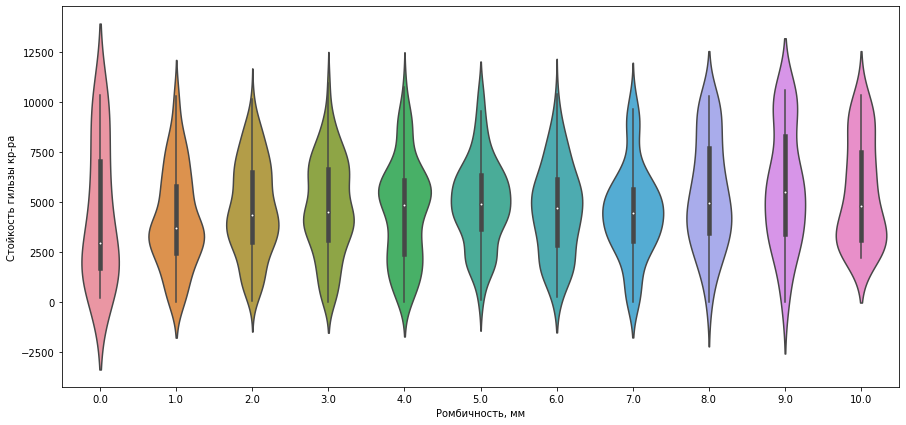

In [229]:
plt.figure(figsize = (15,7))
sns.violinplot(x = 'Ромбичность, мм', y='Стойкость гильзы кр-ра', data = data)

#### Анализ

In [230]:
data['Время от запуска'] = (data['Дата'] - data ['Дата установки']).dt.days
data['Время до выбытия'] = (data['Дата вывода'] - data['Дата']).dt.days
data['Металл до выбытия т'] = data['стойкость на момент выбытия т'] - data['Стойкость гильзы кр-ра']
data['Гарантийные показатели'] = [17000 if x == '180x180' else 13000 for x in data['Размер']]
data['Замечания'] = data['Замечания'].str.lower().str.contains('ромб')

In [231]:
data['Причина'] =data['Причина'].fillna('нет')
data['Марка стали полученная'] = data['Марка стали полученная'].fillna('нет')
data['Марка'] = data['Марка'].fillna('нет')
data = data.fillna(0)

label_encoder = LabelEncoder()
data['Причина'] = pd.Series(label_encoder.fit_transform(data['Причина']))
data['Марка стали полученная'] = pd.Series(label_encoder.fit_transform(data['Марка стали полученная']))
data['Марка'] = pd.Series(label_encoder.fit_transform(data['Марка']))

data['№ гильзы'] = label_encoder.fit_transform(data['№ гильзы'].astype(str))

In [232]:
for column in data.columns:
    data[column].fillna(data[column].mode()[0], inplace=True)


data = data.select_dtypes(exclude=['object'])

### Стандартизируем показатели

In [233]:
# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(data[[d_col]])
    return scaler.transform(data[[d_col]])

In [234]:
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(data.columns):
    if i not in ['стойкость на момент выбытия т']:
        data[i] = StandardScaler_column(i)
        if len(data[data[i].isna()]) < len(data):
            data[i] = data[i].fillna(0)

In [235]:
# проверяем заполнение
display(data.describe().head(1))

,№ гильзы,Дата ввода,№ кристаллизатора,№ ручья_x,Дата установки,Дата вывода,Причина,"стойкость, т",Зазор по шаблону,R1,...,№ ручья_y,№ НЛЗ,"Ромбичность, мм",max,min,Δ,Время от запуска,Время до выбытия,Металл до выбытия т,Гарантийные показатели
count,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,...,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0,23199.0


In [236]:
data = data.groupby('№ гильзы', as_index = False).mean()

### Корреляция

In [237]:
# Отбрасываю несущественную кореляцию
cor = data.corr()
imp_cor = cor[(cor['стойкость на момент выбытия т'] >  0.3)|(cor['стойкость на момент выбытия т'] <  -0.3)]['стойкость на момент выбытия т'].index
data_corr_based = data[imp_cor]

Text(0.5, 1.0, 'Кореляция получившихся колонок')

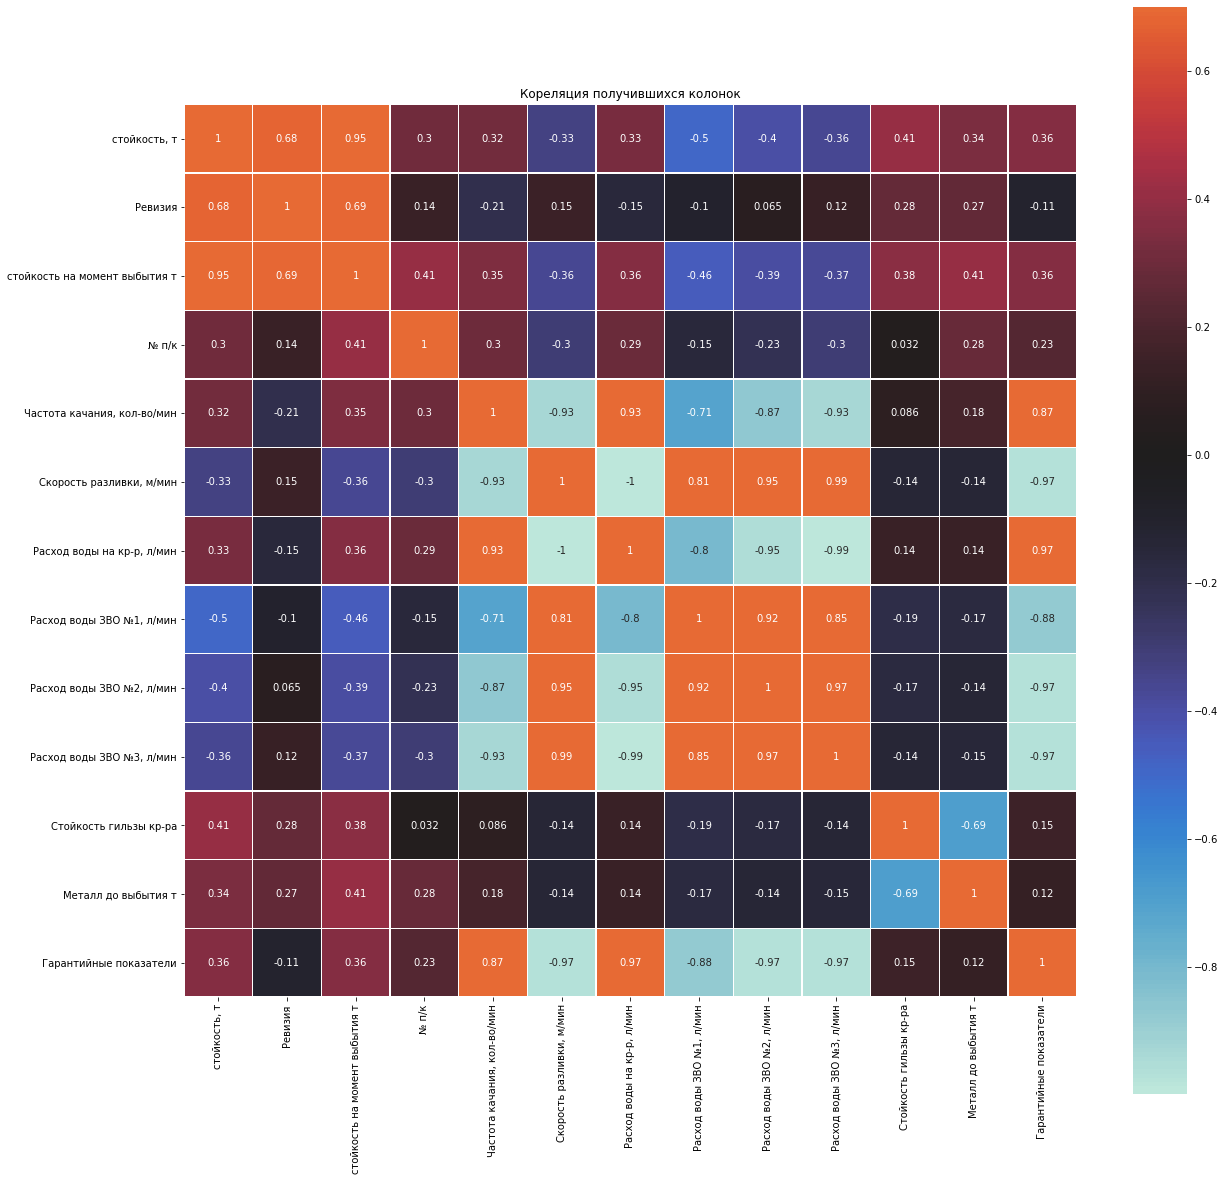

In [238]:
corr = data[imp_cor].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, vmax=0.7, center=0,
            square=True, linewidths=.5 ,annot =True)

plt.title('Кореляция получившихся колонок')

### Разбиваем датасет на тренировочный и тестовый

In [240]:
y = data_corr_based['стойкость на момент выбытия т'].values            # наш таргет
X = data_corr_based.drop(['стойкость на момент выбытия т'], axis=1)

In [241]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED)

In [242]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [243]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [244]:
mae = metrics.mean_absolute_error(y_test,y_pred)
mean = data['стойкость на момент выбытия т'].mean()
mae_percent = mae/mean

print('среднее количество метала до выбытия:', mean)
print('средняя ошибка прогноза: ', mae)
print('средняя ошибка в %:', mae_percent*100, '%')

среднее количество метала до выбытия: 8935.84126984127
средняя ошибка прогноза:  878.6680769230769
средняя ошибка в %: 9.833076152422356 %


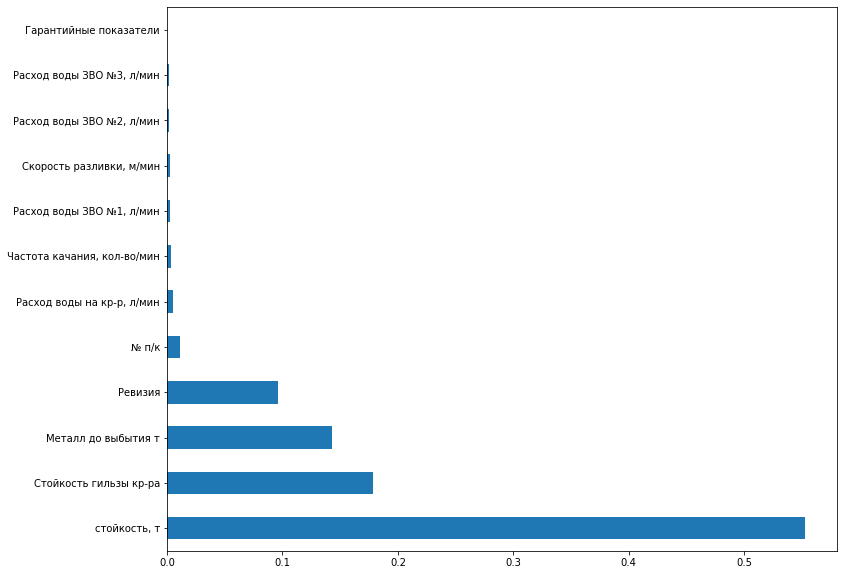

In [245]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### Модель на показателях по железу

In [246]:
steel_metrics = data.filter(like='%').columns.to_list() 
base = ['Металл до выбытия т','Темп 1, °С','Расход воды ЗВО №1, л/мин',\
        'Расход воды ЗВО №2, л/мин','Скорость разливки, м/мин','Ход кр-ра, мм','№ п/п_x', 'стойкость, т','Плавка в серии','Стойкость гильзы кр-ра','№ ручья_x']
steel_cols = steel_metrics + base
data_steel_based = data[steel_cols]

In [247]:
y = data_corr_based['стойкость на момент выбытия т'].values            # наш таргет
X = data_corr_based.drop(['стойкость на момент выбытия т'], axis=1)

In [248]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED)

In [249]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [250]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [251]:
mae = metrics.mean_absolute_error(y_test,y_pred)
mean = data['стойкость на момент выбытия т'].mean()
mae_percent = mae/mean

print('среднее количество метала до выбытия:', mean)
print('средняя ошибка прогноза: ', mae)
print('средняя ошибка в %:', mae_percent*100, '%')

среднее количество метала до выбытия: 8935.84126984127
средняя ошибка прогноза:  878.6680769230769
средняя ошибка в %: 9.833076152422356 %


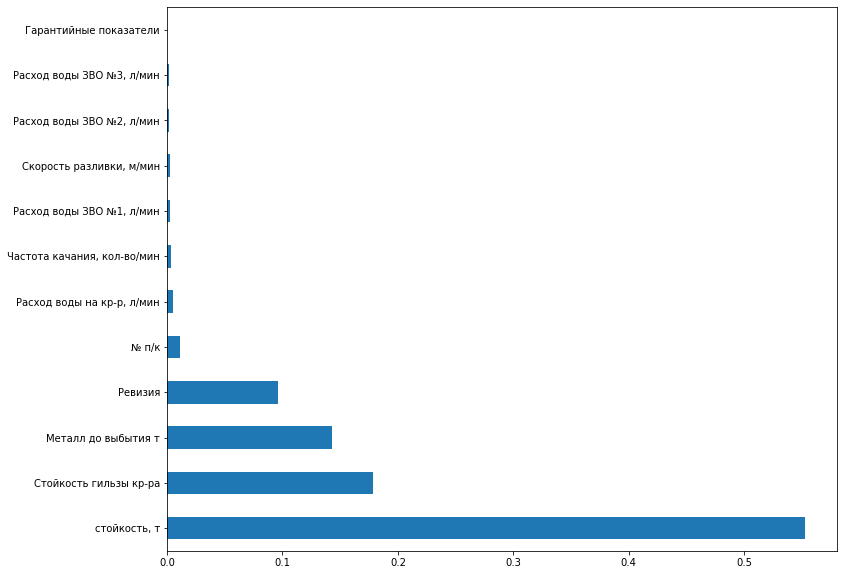

In [252]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')